### Importing the Libraries

In [39]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import torch
import torch.nn.functional as F
from PIL import Image
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
from glob import glob

### Defind the Double Convolution Block

In [145]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

### Define the DownSample Part

In [149]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p
    

### Define the UpSample Part

In [150]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__(),
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

### U-Net Architecture

In [151]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # encoding part
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # bottle neck
        self.bottle_neck = DoubleConv(512, 1024)

        # decoding part
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        # out
        self.out = nn.Conv2d(64, out_channels=num_classes, kernel_size=1)


    def forward(self, x):
        # encoding part
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        # bottle neck
        b = self.bottle_neck(p4)

        # decoding part
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        # out
        out = self.out(up_4)
        return out

### Train the model

In [152]:
class BrainTumor_dataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted(glob(os.path.join(root_path, "images", "*.png")))[:self.limit]
        self.masks = sorted(glob(os.path.join(root_path, "masks", "*.png")))[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return min(len(self.images), self.limit)
        

In [153]:
# training on kaggle
print(os.listdir("/kaggle/input/brain-tumor-segmentation"))
DATASET_DIR = "/kaggle/input/brain-tumor-segmentation"


['images', 'masks']


In [154]:
train_dataset = BrainTumor_dataset(DATASET_DIR)
generator = torch.Generator().manual_seed(25)

In [155]:
train_dataset, test_dataset = random_split(train_dataset, [0.6, 0.4], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

len(train_dataset), len(val_dataset), len(test_dataset)

(1839, 612, 613)

In [156]:
# set up GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

device

'cuda'

In [157]:
num_workers

4

### Set up DataLoaders for training

In [158]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset,
                             num_workers=num_workers, 
                             pin_memory=False,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                             num_workers=num_workers, 
                             pin_memory=False,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             num_workers=num_workers, 
                             pin_memory=False,
                             batch_size=BATCH_SIZE,
                             shuffle=True)


In [161]:
def dice_coefficient(prediction, target, smooth=1e-07):
    pred = torch.sigmoid(prediction.clone())  # (N, 1, H, W) -> probabilities
    pred = pred.contiguous().view(pred.size(0), -1)   # (N, H*W)
    target = target.contiguous().view(target.size(0), -1)  # (N, H*W)

    intersection = (pred * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (pred.sum(dim=1) + target.sum(dim=1) + smooth)

    return dice.mean()


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)

        intersection = (pred * target).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (
            pred.sum(dim=1) + target.sum(dim=1) + self.smooth
        )
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss



In [162]:
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = BCEDiceLoss(weight_bce=0.2, weight_dice=0.8)
# criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7, verbose=True
)


In [163]:
torch.cuda.empty_cache()

### Training the model

In [164]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, model, score):
        if self.best_score is None:
            self.best_score = score
            torch.save(model.state_dict(), '/kaggle/working/my_checkpoint.pth')
            return 'save model'
            
        elif score > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return 'no save model'
        else:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), '/kaggle/working/my_checkpoint.pth')
            return 'save model'

early_stopping = EarlyStopping(patience=20, delta=0.01)
"early_stopping"

'early_stopping'

In [165]:
EPOCHS = 200
train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):

    # training
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)

        train_running_loss += loss.item()
        train_running_dc += dc.item()
        
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)  

    # evaluation
    model.eval()
    val_running_loss = 0
    val_running_sc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)

            val_running_loss += loss.item()
            val_running_sc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_sc / (idx + 1)
        
    val_losses.append(val_loss)
    val_dcs.append(val_dc)
    scheduler.step(val_loss)
    
    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    
    print(early_stopping(model, val_loss))
    if early_stopping.early_stop:
        break
    print("-" * 30)

100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 1: 0.8040
Training DICE EPOCH 1: 0.0523


Validation Loss EPOCH 1: 0.7472
Validation DICE EPOCH 1: 0.0968


  0%|          | 1/200 [00:47<2:36:41, 47.25s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.05it/s]


------------------------------
Training Loss EPOCH 2: 0.7071
Training DICE EPOCH 2: 0.1453


Validation Loss EPOCH 2: 0.6360
Validation DICE EPOCH 2: 0.2344


  1%|          | 2/200 [01:34<2:35:42, 47.18s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 3: 0.5700
Training DICE EPOCH 3: 0.3166


Validation Loss EPOCH 3: 0.5859
Validation DICE EPOCH 3: 0.3019


  2%|▏         | 3/200 [02:21<2:35:01, 47.22s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 4: 0.4991
Training DICE EPOCH 4: 0.4021


Validation Loss EPOCH 4: 0.4458
Validation DICE EPOCH 4: 0.4680


  2%|▏         | 4/200 [03:08<2:34:16, 47.23s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.02it/s]


------------------------------
Training Loss EPOCH 5: 0.4417
Training DICE EPOCH 5: 0.4728


Validation Loss EPOCH 5: 0.4251
Validation DICE EPOCH 5: 0.4956


  2%|▎         | 5/200 [03:56<2:33:31, 47.24s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 6: 0.4035
Training DICE EPOCH 6: 0.5192


Validation Loss EPOCH 6: 0.4124
Validation DICE EPOCH 6: 0.5058


  3%|▎         | 6/200 [04:43<2:32:50, 47.27s/it]

save model
------------------------------


  4%|▎         | 7/200 [05:30<2:31:40, 47.15s/it]

------------------------------
Training Loss EPOCH 7: 0.4076
Training DICE EPOCH 7: 0.5142


Validation Loss EPOCH 7: 0.4229
Validation DICE EPOCH 7: 0.4946
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 8: 0.3879
Training DICE EPOCH 8: 0.5377


Validation Loss EPOCH 8: 0.3836
Validation DICE EPOCH 8: 0.5411


  4%|▍         | 8/200 [06:17<2:30:56, 47.17s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 9: 0.3579
Training DICE EPOCH 9: 0.5741


Validation Loss EPOCH 9: 0.3776
Validation DICE EPOCH 9: 0.5510


  4%|▍         | 9/200 [07:04<2:30:14, 47.20s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  6.98it/s]


------------------------------
Training Loss EPOCH 10: 0.3443
Training DICE EPOCH 10: 0.5898


Validation Loss EPOCH 10: 0.3605
Validation DICE EPOCH 10: 0.5692


  5%|▌         | 10/200 [07:52<2:29:32, 47.22s/it]

save model
------------------------------


  6%|▌         | 11/200 [08:39<2:28:26, 47.12s/it]

------------------------------
Training Loss EPOCH 11: 0.3375
Training DICE EPOCH 11: 0.5985


Validation Loss EPOCH 11: 0.4043
Validation DICE EPOCH 11: 0.5210
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 12: 0.3343
Training DICE EPOCH 12: 0.6019


Validation Loss EPOCH 12: 0.3518
Validation DICE EPOCH 12: 0.5787


  6%|▌         | 12/200 [09:26<2:27:42, 47.14s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 13: 0.3215
Training DICE EPOCH 13: 0.6175


Validation Loss EPOCH 13: 0.3436
Validation DICE EPOCH 13: 0.5896


  6%|▋         | 13/200 [10:13<2:27:02, 47.18s/it]

save model
------------------------------


  7%|▋         | 14/200 [11:00<2:26:01, 47.11s/it]

------------------------------
Training Loss EPOCH 14: 0.3045
Training DICE EPOCH 14: 0.6378


Validation Loss EPOCH 14: 0.3483
Validation DICE EPOCH 14: 0.5883
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.04it/s]


------------------------------
Training Loss EPOCH 15: 0.2950
Training DICE EPOCH 15: 0.6486


Validation Loss EPOCH 15: 0.3175
Validation DICE EPOCH 15: 0.6203


  8%|▊         | 15/200 [11:47<2:25:21, 47.14s/it]

save model
------------------------------


  8%|▊         | 16/200 [12:34<2:24:22, 47.08s/it]

------------------------------
Training Loss EPOCH 16: 0.2769
Training DICE EPOCH 16: 0.6702


Validation Loss EPOCH 16: 0.3379
Validation DICE EPOCH 16: 0.5967
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 17: 0.2657
Training DICE EPOCH 17: 0.6836


Validation Loss EPOCH 17: 0.3108
Validation DICE EPOCH 17: 0.6293


  8%|▊         | 17/200 [13:21<2:23:43, 47.12s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 18: 0.2583
Training DICE EPOCH 18: 0.6923


Validation Loss EPOCH 18: 0.3086
Validation DICE EPOCH 18: 0.6322


  9%|▉         | 18/200 [14:09<2:23:01, 47.15s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 19: 0.2521
Training DICE EPOCH 19: 0.6999


Validation Loss EPOCH 19: 0.3078
Validation DICE EPOCH 19: 0.6335


 10%|▉         | 19/200 [14:56<2:22:18, 47.17s/it]

save model
------------------------------


 10%|█         | 20/200 [15:43<2:21:17, 47.10s/it]

------------------------------
Training Loss EPOCH 20: 0.2753
Training DICE EPOCH 20: 0.6721


Validation Loss EPOCH 20: 0.3387
Validation DICE EPOCH 20: 0.5972
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.07it/s]


------------------------------
Training Loss EPOCH 21: 0.2566
Training DICE EPOCH 21: 0.6946


Validation Loss EPOCH 21: 0.3005
Validation DICE EPOCH 21: 0.6422


 10%|█         | 21/200 [16:30<2:20:34, 47.12s/it]

save model
------------------------------


 11%|█         | 22/200 [17:17<2:19:36, 47.06s/it]

------------------------------
Training Loss EPOCH 22: 0.2436
Training DICE EPOCH 22: 0.7098


Validation Loss EPOCH 22: 0.3302
Validation DICE EPOCH 22: 0.6082
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.04it/s]


------------------------------
Training Loss EPOCH 23: 0.2476
Training DICE EPOCH 23: 0.7053


Validation Loss EPOCH 23: 0.2913
Validation DICE EPOCH 23: 0.6524


 12%|█▏        | 23/200 [18:04<2:18:58, 47.11s/it]

save model
------------------------------


 12%|█▏        | 24/200 [18:51<2:18:03, 47.06s/it]

------------------------------
Training Loss EPOCH 24: 0.2329
Training DICE EPOCH 24: 0.7224


Validation Loss EPOCH 24: 0.3240
Validation DICE EPOCH 24: 0.6141
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.05it/s]


------------------------------
Training Loss EPOCH 25: 0.2188
Training DICE EPOCH 25: 0.7392


Validation Loss EPOCH 25: 0.2860
Validation DICE EPOCH 25: 0.6594


 12%|█▎        | 25/200 [19:38<2:17:23, 47.11s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 26: 0.2135
Training DICE EPOCH 26: 0.7456


Validation Loss EPOCH 26: 0.2787
Validation DICE EPOCH 26: 0.6669


 13%|█▎        | 26/200 [20:25<2:16:42, 47.14s/it]

save model
------------------------------


 14%|█▎        | 27/200 [21:12<2:15:42, 47.07s/it]

------------------------------
Training Loss EPOCH 27: 0.2101
Training DICE EPOCH 27: 0.7495


Validation Loss EPOCH 27: 0.3047
Validation DICE EPOCH 27: 0.6380
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.01it/s]


------------------------------
Training Loss EPOCH 28: 0.2088
Training DICE EPOCH 28: 0.7513


Validation Loss EPOCH 28: 0.2704
Validation DICE EPOCH 28: 0.6762


 14%|█▍        | 28/200 [22:00<2:15:05, 47.13s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.03it/s]


------------------------------
Training Loss EPOCH 29: 0.2070
Training DICE EPOCH 29: 0.7536


Validation Loss EPOCH 29: 0.2638
Validation DICE EPOCH 29: 0.6851


 14%|█▍        | 29/200 [22:47<2:14:24, 47.16s/it]

save model
------------------------------


 15%|█▌        | 30/200 [23:34<2:13:26, 47.10s/it]

------------------------------
Training Loss EPOCH 30: 0.1928
Training DICE EPOCH 30: 0.7701


Validation Loss EPOCH 30: 0.2713
Validation DICE EPOCH 30: 0.6749
no save model
------------------------------


 16%|█▌        | 31/200 [24:21<2:12:33, 47.06s/it]

------------------------------
Training Loss EPOCH 31: 0.1845
Training DICE EPOCH 31: 0.7799


Validation Loss EPOCH 31: 0.2734
Validation DICE EPOCH 31: 0.6733
no save model
------------------------------


 16%|█▌        | 32/200 [25:08<2:11:38, 47.02s/it]

------------------------------
Training Loss EPOCH 32: 0.1727
Training DICE EPOCH 32: 0.7937


Validation Loss EPOCH 32: 0.2687
Validation DICE EPOCH 32: 0.6777
no save model
------------------------------


 16%|█▋        | 33/200 [25:55<2:10:52, 47.02s/it]

------------------------------
Training Loss EPOCH 33: 0.1651
Training DICE EPOCH 33: 0.8029


Validation Loss EPOCH 33: 0.2671
Validation DICE EPOCH 33: 0.6808
no save model
------------------------------


 17%|█▋        | 34/200 [26:42<2:10:01, 46.99s/it]

------------------------------
Training Loss EPOCH 34: 0.1948
Training DICE EPOCH 34: 0.7677


Validation Loss EPOCH 34: 0.2703
Validation DICE EPOCH 34: 0.6792
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.04it/s]


------------------------------
Training Loss EPOCH 35: 0.1828
Training DICE EPOCH 35: 0.7817


Validation Loss EPOCH 35: 0.2473
Validation DICE EPOCH 35: 0.7051


 18%|█▊        | 35/200 [27:29<2:09:24, 47.06s/it]

save model
------------------------------


 18%|█▊        | 36/200 [28:16<2:08:30, 47.02s/it]

------------------------------
Training Loss EPOCH 36: 0.1531
Training DICE EPOCH 36: 0.8170


Validation Loss EPOCH 36: 0.2635
Validation DICE EPOCH 36: 0.6864
no save model
------------------------------


 18%|█▊        | 37/200 [29:03<2:07:37, 46.98s/it]

------------------------------
Training Loss EPOCH 37: 0.1622
Training DICE EPOCH 37: 0.8066


Validation Loss EPOCH 37: 0.3122
Validation DICE EPOCH 37: 0.6306
no save model
------------------------------


 19%|█▉        | 38/200 [29:49<2:06:47, 46.96s/it]

------------------------------
Training Loss EPOCH 38: 0.1670
Training DICE EPOCH 38: 0.8006


Validation Loss EPOCH 38: 0.2840
Validation DICE EPOCH 38: 0.6631
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.02it/s]


------------------------------
Training Loss EPOCH 39: 0.1571
Training DICE EPOCH 39: 0.8125


Validation Loss EPOCH 39: 0.2439
Validation DICE EPOCH 39: 0.7091


 20%|█▉        | 39/200 [30:37<2:06:13, 47.04s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.04it/s]


------------------------------
Training Loss EPOCH 40: 0.1378
Training DICE EPOCH 40: 0.8353


Validation Loss EPOCH 40: 0.2395
Validation DICE EPOCH 40: 0.7150


 20%|██        | 40/200 [31:24<2:05:35, 47.09s/it]

save model
------------------------------


 20%|██        | 41/200 [32:11<2:04:39, 47.04s/it]

------------------------------
Training Loss EPOCH 41: 0.1410
Training DICE EPOCH 41: 0.8314


Validation Loss EPOCH 41: 0.2534
Validation DICE EPOCH 41: 0.6969
no save model
------------------------------


 21%|██        | 42/200 [32:58<2:03:46, 47.00s/it]

------------------------------
Training Loss EPOCH 42: 0.1315
Training DICE EPOCH 42: 0.8427


Validation Loss EPOCH 42: 0.2420
Validation DICE EPOCH 42: 0.7111
no save model
------------------------------


 22%|██▏       | 43/200 [33:45<2:02:56, 46.98s/it]

------------------------------
Training Loss EPOCH 43: 0.1523
Training DICE EPOCH 43: 0.8181


Validation Loss EPOCH 43: 0.2801
Validation DICE EPOCH 43: 0.6669
no save model
------------------------------


 22%|██▏       | 44/200 [34:32<2:02:10, 46.99s/it]

------------------------------
Training Loss EPOCH 44: 0.1344
Training DICE EPOCH 44: 0.8395


Validation Loss EPOCH 44: 0.2499
Validation DICE EPOCH 44: 0.7020
no save model
------------------------------


 22%|██▎       | 45/200 [35:19<2:01:20, 46.97s/it]

------------------------------
Training Loss EPOCH 45: 0.1254
Training DICE EPOCH 45: 0.8499


Validation Loss EPOCH 45: 0.2419
Validation DICE EPOCH 45: 0.7115
no save model
------------------------------


 23%|██▎       | 46/200 [36:06<2:00:29, 46.95s/it]

------------------------------
Training Loss EPOCH 46: 0.1208
Training DICE EPOCH 46: 0.8555


Validation Loss EPOCH 46: 0.2627
Validation DICE EPOCH 46: 0.6854
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.01it/s]


------------------------------
Training Loss EPOCH 47: 0.1163
Training DICE EPOCH 47: 0.8605


Validation Loss EPOCH 47: 0.2386
Validation DICE EPOCH 47: 0.7156


 24%|██▎       | 47/200 [36:53<1:59:57, 47.04s/it]

save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 48: 0.1079
Training DICE EPOCH 48: 0.8708


Validation Loss EPOCH 48: 0.2385
Validation DICE EPOCH 48: 0.7162


 24%|██▍       | 48/200 [37:40<1:59:19, 47.10s/it]

save model
------------------------------


 24%|██▍       | 49/200 [38:27<1:58:23, 47.04s/it]

------------------------------
Training Loss EPOCH 49: 0.1030
Training DICE EPOCH 49: 0.8765


Validation Loss EPOCH 49: 0.2386
Validation DICE EPOCH 49: 0.7162
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.04it/s]


------------------------------
Training Loss EPOCH 50: 0.1008
Training DICE EPOCH 50: 0.8792


Validation Loss EPOCH 50: 0.2380
Validation DICE EPOCH 50: 0.7164


 25%|██▌       | 50/200 [39:14<1:57:45, 47.10s/it]

save model
------------------------------


 26%|██▌       | 51/200 [40:01<1:56:49, 47.04s/it]

------------------------------
Training Loss EPOCH 51: 0.0988
Training DICE EPOCH 51: 0.8816


Validation Loss EPOCH 51: 0.2393
Validation DICE EPOCH 51: 0.7151
no save model
------------------------------


 26%|██▌       | 52/200 [40:48<1:55:56, 47.00s/it]

------------------------------
Training Loss EPOCH 52: 0.0974
Training DICE EPOCH 52: 0.8833


Validation Loss EPOCH 52: 0.2402
Validation DICE EPOCH 52: 0.7138
no save model
------------------------------


 26%|██▋       | 53/200 [41:35<1:55:05, 46.98s/it]

------------------------------
Training Loss EPOCH 53: 0.0963
Training DICE EPOCH 53: 0.8847


Validation Loss EPOCH 53: 0.2403
Validation DICE EPOCH 53: 0.7138
no save model
------------------------------


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


------------------------------
Training Loss EPOCH 54: 0.0954
Training DICE EPOCH 54: 0.8858


Validation Loss EPOCH 54: 0.2356
Validation DICE EPOCH 54: 0.7197


 27%|██▋       | 54/200 [42:22<1:54:28, 47.05s/it]

save model
------------------------------


 28%|██▊       | 55/200 [43:09<1:53:36, 47.01s/it]

------------------------------
Training Loss EPOCH 55: 0.0941
Training DICE EPOCH 55: 0.8873


Validation Loss EPOCH 55: 0.2442
Validation DICE EPOCH 55: 0.7092
no save model
------------------------------


 28%|██▊       | 56/200 [43:56<1:52:46, 46.99s/it]

------------------------------
Training Loss EPOCH 56: 0.0929
Training DICE EPOCH 56: 0.8887


Validation Loss EPOCH 56: 0.2393
Validation DICE EPOCH 56: 0.7153
no save model
------------------------------


 28%|██▊       | 57/200 [44:43<1:51:55, 46.96s/it]

------------------------------
Training Loss EPOCH 57: 0.0917
Training DICE EPOCH 57: 0.8902


Validation Loss EPOCH 57: 0.2390
Validation DICE EPOCH 57: 0.7154
no save model
------------------------------


 29%|██▉       | 58/200 [45:30<1:51:12, 46.99s/it]

------------------------------
Training Loss EPOCH 58: 0.0907
Training DICE EPOCH 58: 0.8914


Validation Loss EPOCH 58: 0.2389
Validation DICE EPOCH 58: 0.7157
no save model
------------------------------


 30%|██▉       | 59/200 [46:17<1:50:21, 46.96s/it]

------------------------------
Training Loss EPOCH 59: 0.0896
Training DICE EPOCH 59: 0.8927


Validation Loss EPOCH 59: 0.2404
Validation DICE EPOCH 59: 0.7141
no save model
------------------------------


 30%|███       | 60/200 [47:04<1:49:35, 46.97s/it]

------------------------------
Training Loss EPOCH 60: 0.0886
Training DICE EPOCH 60: 0.8938


Validation Loss EPOCH 60: 0.2440
Validation DICE EPOCH 60: 0.7099
no save model
------------------------------


 30%|███       | 61/200 [47:51<1:48:45, 46.95s/it]

------------------------------
Training Loss EPOCH 61: 0.0876
Training DICE EPOCH 61: 0.8951


Validation Loss EPOCH 61: 0.2399
Validation DICE EPOCH 61: 0.7145
no save model
------------------------------


 31%|███       | 62/200 [48:38<1:47:57, 46.94s/it]

------------------------------
Training Loss EPOCH 62: 0.0873
Training DICE EPOCH 62: 0.8954


Validation Loss EPOCH 62: 0.2401
Validation DICE EPOCH 62: 0.7144
no save model
------------------------------


 32%|███▏      | 63/200 [49:25<1:47:10, 46.94s/it]

------------------------------
Training Loss EPOCH 63: 0.0871
Training DICE EPOCH 63: 0.8956


Validation Loss EPOCH 63: 0.2423
Validation DICE EPOCH 63: 0.7119
no save model
------------------------------


 32%|███▏      | 64/200 [50:12<1:46:22, 46.93s/it]

------------------------------
Training Loss EPOCH 64: 0.0870
Training DICE EPOCH 64: 0.8958


Validation Loss EPOCH 64: 0.2463
Validation DICE EPOCH 64: 0.7068
no save model
------------------------------


 32%|███▎      | 65/200 [50:58<1:45:35, 46.93s/it]

------------------------------
Training Loss EPOCH 65: 0.0869
Training DICE EPOCH 65: 0.8959


Validation Loss EPOCH 65: 0.2460
Validation DICE EPOCH 65: 0.7076
no save model
------------------------------


 33%|███▎      | 66/200 [51:45<1:44:47, 46.92s/it]

------------------------------
Training Loss EPOCH 66: 0.0868
Training DICE EPOCH 66: 0.8960


Validation Loss EPOCH 66: 0.2407
Validation DICE EPOCH 66: 0.7139
no save model
------------------------------


 34%|███▎      | 67/200 [52:32<1:44:03, 46.95s/it]

------------------------------
Training Loss EPOCH 67: 0.0866
Training DICE EPOCH 67: 0.8963


Validation Loss EPOCH 67: 0.2392
Validation DICE EPOCH 67: 0.7155
no save model
------------------------------


 34%|███▍      | 68/200 [53:19<1:43:16, 46.94s/it]

------------------------------
Training Loss EPOCH 68: 0.0866
Training DICE EPOCH 68: 0.8963


Validation Loss EPOCH 68: 0.2428
Validation DICE EPOCH 68: 0.7112
no save model
------------------------------


 34%|███▍      | 69/200 [54:06<1:42:27, 46.93s/it]

------------------------------
Training Loss EPOCH 69: 0.0866
Training DICE EPOCH 69: 0.8963


Validation Loss EPOCH 69: 0.2446
Validation DICE EPOCH 69: 0.7091
no save model
------------------------------


 35%|███▌      | 70/200 [54:53<1:41:39, 46.92s/it]

------------------------------
Training Loss EPOCH 70: 0.0866
Training DICE EPOCH 70: 0.8963


Validation Loss EPOCH 70: 0.2428
Validation DICE EPOCH 70: 0.7110
no save model
------------------------------


 36%|███▌      | 71/200 [55:40<1:40:51, 46.91s/it]

------------------------------
Training Loss EPOCH 71: 0.0865
Training DICE EPOCH 71: 0.8963


Validation Loss EPOCH 71: 0.2421
Validation DICE EPOCH 71: 0.7120
no save model
------------------------------


 36%|███▌      | 72/200 [56:27<1:40:03, 46.90s/it]

------------------------------
Training Loss EPOCH 72: 0.0866
Training DICE EPOCH 72: 0.8963


Validation Loss EPOCH 72: 0.2429
Validation DICE EPOCH 72: 0.7112
no save model
------------------------------


 36%|███▋      | 73/200 [57:14<1:39:17, 46.91s/it]

------------------------------
Training Loss EPOCH 73: 0.0866
Training DICE EPOCH 73: 0.8963


Validation Loss EPOCH 73: 0.2407
Validation DICE EPOCH 73: 0.7138
no save model
------------------------------


 36%|███▋      | 73/200 [58:01<1:40:56, 47.69s/it]

------------------------------
Training Loss EPOCH 74: 0.0865
Training DICE EPOCH 74: 0.8964


Validation Loss EPOCH 74: 0.2399
Validation DICE EPOCH 74: 0.7146
no save model


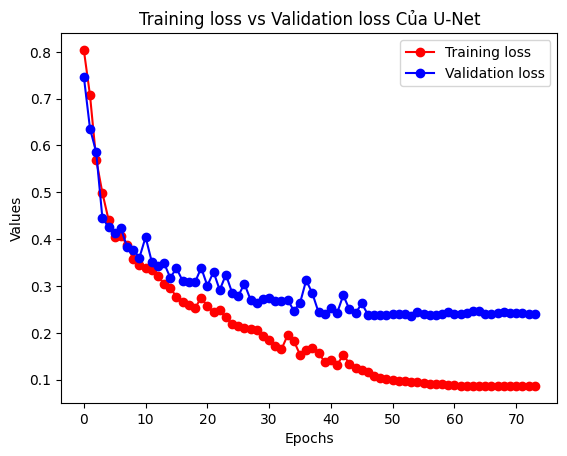

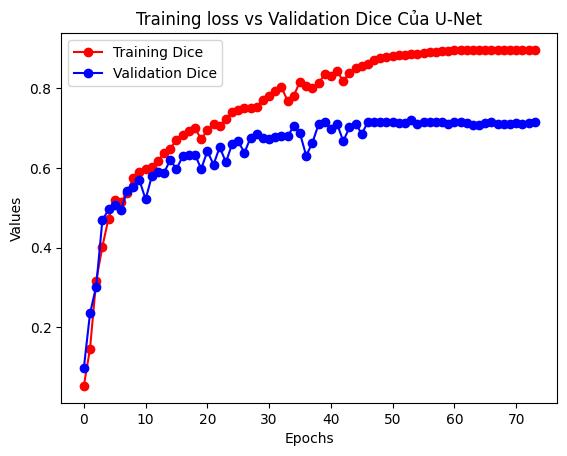

In [166]:
positions = np.arange(len(train_losses))
plt.plot(positions, train_losses, marker='o', linestyle='-', color='r', label='Training loss')
plt.plot(positions, val_losses, marker='o', linestyle='-', color='b', label='Validation loss')
# thêm các thuộc tính của biểu đồ
plt.title("Training loss vs Validation loss Của U-Net")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.legend()
plt.show()


plt.plot(positions, train_dcs, marker='o', linestyle='-', color='r', label='Training Dice')
plt.plot(positions, val_dcs, marker='o', linestyle='-', color='b', label='Validation Dice')
# thêm các thuộc tính của biểu đồ
plt.title("Training loss vs Validation Dice Của U-Net")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.legend()
plt.show()

### Test

In [167]:
model_pth = '/kaggle/working/my_checkpoint.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

/tmp/ipykernel_31/2925297660.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


<All keys matched successfully>

In [168]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)
    print(f"test Loss EPOCH {epoch + 1}: {test_loss:.4f}")
    print(f"test DICE EPOCH {epoch + 1}: {test_dc:.4f}")

100%|██████████| 39/39 [00:05<00:00,  6.85it/s]

test Loss EPOCH 74: 0.2056
test DICE EPOCH 74: 0.7564


  0%|          | 0/39 [00:00<?, ?it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.7969, device='cuda:0')


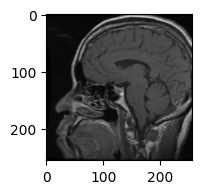

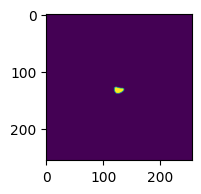

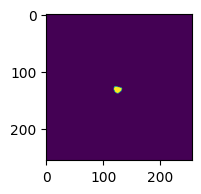

  3%|▎         | 1/39 [00:00<00:28,  1.32it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.9015, device='cuda:0')


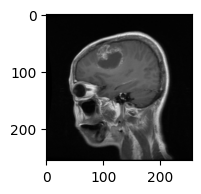

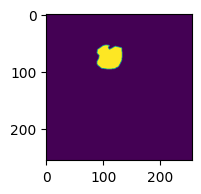

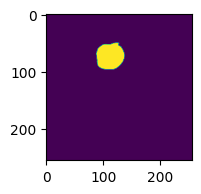

  5%|▌         | 2/39 [00:01<00:17,  2.09it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.9335, device='cuda:0')


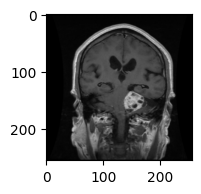

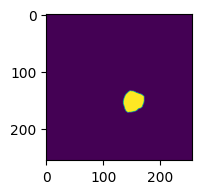

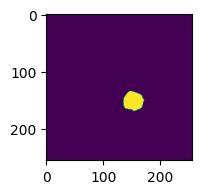

  8%|▊         | 3/39 [00:01<00:13,  2.63it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.9044, device='cuda:0')


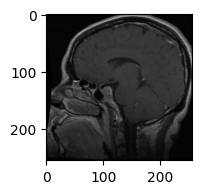

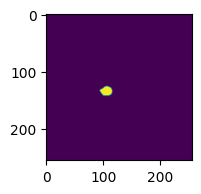

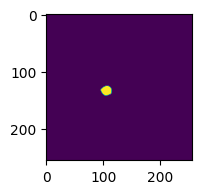

 10%|█         | 4/39 [00:01<00:15,  2.28it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.8614, device='cuda:0')


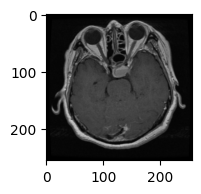

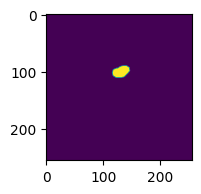

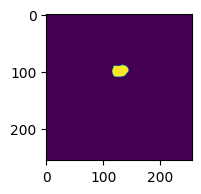

 13%|█▎        | 5/39 [00:02<00:12,  2.65it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.9132, device='cuda:0')


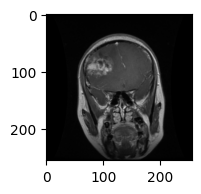

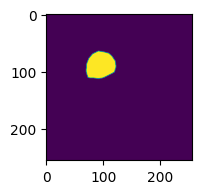

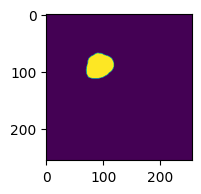

 15%|█▌        | 6/39 [00:02<00:11,  2.79it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.7925, device='cuda:0')


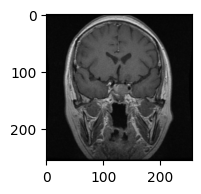

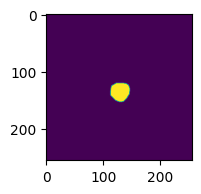

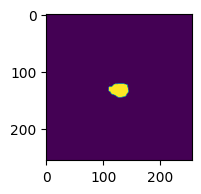

 18%|█▊        | 7/39 [00:02<00:10,  2.99it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.7849, device='cuda:0')


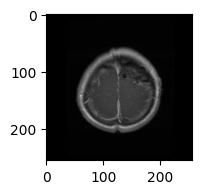

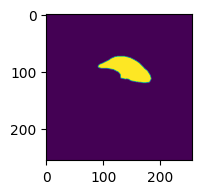

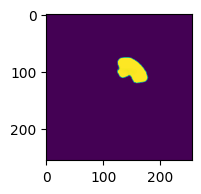

 21%|██        | 8/39 [00:02<00:09,  3.25it/s]

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
dc:  tensor(0.0002, device='cuda:0')


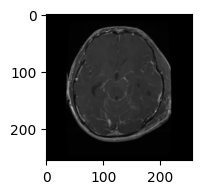

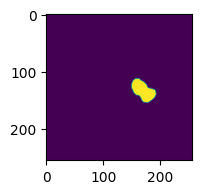

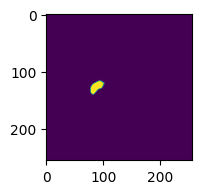

 21%|██        | 8/39 [00:03<00:12,  2.40it/s]


In [169]:
with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0][0].float().unsqueeze(0).to(device)
        mask = img_mask[1][0].float().unsqueeze(0).to(device)
        print(img.shape, mask.shape)
        y_pred = trained_model(img)
        dc = dice_coefficient(y_pred, mask)
        print("dc: ", dc)
        y_pred = y_pred[0].cpu()
        y_pred = torch.sigmoid(y_pred)
    
        plt.subplot(1,3,1)
        plt.imshow(img[0].cpu().permute(1, 2, 0))
        plt.show()

        plt.subplot(1,3,2)
        plt.imshow(mask[0].cpu().permute(1, 2, 0))
        plt.show()

        plt.subplot(1,3,1)
        plt.imshow(y_pred.permute(1, 2, 0))
        plt.show()
        if idx == 8:
            break